only considering seasons 1969-2019, since it will give us ~3000 positively-labeled data points (32 players*2 teams * 50 years)

only position players (no pitchers or catchers)

In this notebook, I'll build a Gaussian Naive Bayes Classifier to predict MLB Allstar appearances for position players (not pitchers or catchers).
We'll train this classifier using data from 1969-2009

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from matplotlib import pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
def format_people(people):
    #keep only the important columns--no names because we won't want them as features of our model
    people = people[['playerID', 'birthYear', 'birthMonth', 'birthDay', 'debut']]
    #drop rows with NA
    people = people.dropna()
    #cast dates to ints, then strings, then concat and cast to datetime
    people.birthYear = people.birthYear.astype(int)
    people.birthDay = people.birthDay.astype(int)
    people.birthMonth = people.birthMonth.astype(int)
    people.birthYear = people.birthYear.astype(str)
    people.birthDay = people.birthDay.astype(str)
    people.birthMonth = people.birthMonth.astype(str)
    people['bday'] = people['birthYear'] + '-' + people['birthMonth'] + '-' + people['birthDay']
    people.bday = pd.to_datetime(people.bday, infer_datetime_format=True)
    #cast debut to datetime also
    people.debut = pd.to_datetime(people.debut, infer_datetime_format=True)
    #get rid of the 3 date cols that we combined
    people = people[['playerID', 'bday', 'debut']]
    return people

def format_batting(batting):
    #get only the data for 1968 and on
    batting = batting[batting.yearID >1968]
    #drop irrelevant cols-don't need to include teamID and lgID because teams and leagues should have equal representation,
    #so it shouldn't have any effect on whether or not a player makes it.  The others aren't expected to have predictive power.
    batting = batting.drop(['teamID', 'lgID', 'CS', 'HBP', 'SH', 'SF', 'GIDP'], axis=1)
    #drop nas
    batting = batting.dropna()
    #make a lambda function to sum the columns in the following line
    add = lambda x: x.astype(int).sum()
    #group by player number and yearID to sum stats for players who have >1 stint in a year
    batting = batting.groupby(['playerID', 'yearID'])['G', 'AB', 'R', 'H', 'HR', 'RBI', 'SB', 'BB', 'SO', 'IBB'].apply(add)
    #collapse multi-index
    batting = batting.reset_index()
    return batting

def format_fielding(fielding):
    #get only the data for 1968 and on
    fielding = fielding[fielding.yearID >1968]
    #drop irrelevant cols-drop team, league, stint, GS, InnOuts bc not relevant/multicollinear
    #drop the rest bc they pertain to pitchers and catchers
    fielding = fielding.drop(['teamID', 'stint', 'lgID', 'GS', 'InnOuts', 'PB', 'WP', 'CS', 'ZR', 'G', 'SB'], axis=1)
    #drop pitchers and catchers
    fielding = fielding[fielding['POS']!='C']
    fielding = fielding[fielding['POS']!='P']
    #drop nas
    fielding = fielding.dropna()
    #make lambda
    add = lambda x:x.astype(int).sum()
    #group by playerID and year, then sum other cols
    fielding = fielding.groupby(['playerID', 'yearID'])[ 'PO', 'A', 'E', 'DP'].apply(add)
    
    fielding = fielding.reset_index()
    return fielding


def format_allstars(allstars):
    #get only 1968 and on
    allstars = allstars[allstars.yearID>1968]
    #drop irrelevant columns
    allstars = allstars.drop(['teamID', 'lgID', 'GP', 'startingPos', 'gameID', 'gameNum'], axis=1)
    allstars['star'] = 1
    return allstars

def format_data(people, batting, fielding, allstars):
    fp = format_people(people)
    fb = format_batting(batting)
    ff = format_fielding(fielding)
    fa = format_allstars(allstars)
    
    #merge the DFs
    pb = fp.merge(fb, on='playerID', how='inner')
    pbf = pb.merge(ff, on=['playerID', 'yearID'], how='inner')
    df = pbf.merge(fa, on=['playerID', 'yearID'], how='left')
    #fill in the NaNs in df.star and cast to int
    df['star'] = df['star'].fillna(0.0)
    df['star'] = df['star'].astype(int)
    df = df.drop(['playerID', 'yearID', 'bday', 'debut'], axis=1)

    #split into X and y (features and labels)
    X = df.drop(['star'], axis=1)
    y = df['star']
    return (X, y)

    
def plot_pr(y_test, y_hat):
    precision, recall, t = metrics.precision_recall_curve(y_test, y_hat)
    plt.plot(precision, recall)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('precision')
    plt.ylabel('recall')
    plt.title('Precision-Recall Curve')
    plt.show()
    
def plot_auc(y_test, y_hat):
    print("sklearn ROC AUC Score A:", metrics.roc_auc_score(y_test, y_hat))
    fpr, tpr, _ = metrics.roc_curve(y_test, y_hat)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') #center line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [3]:
#read the files into DFs from csv
people = pd.read_csv('People.csv')
batting = pd.read_csv('Batting.csv')
fielding = pd.read_csv('Fielding.csv')
allstars = pd.read_csv('AllstarFull.csv')

#format the input data
X, y = format_data(people, batting, fielding, allstars)


Use sklearn to train and evaluate our Guassian Naive Bayes Classifier.

Accuracy:  0.8115971107544141
Recall:  0.8997429305912596
Precision:  0.28
F1 Score:  0.42708968883465537
ROC AUC:  0.8519389299311032
Confusion Matrix: 
 [[3695  900]
 [  39  350]] 
[[TN FP] 
[FN TP]]


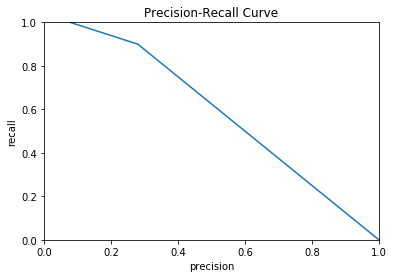

sklearn ROC AUC Score A: 0.8519389299311032


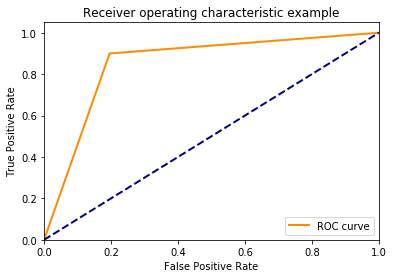

In [4]:
#split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=88)

#create the classifier
model = GaussianNB()

#train the model
model.fit(X_train, y_train)

#predict output
y_hat = model.predict(X_test)

#evaluate
print('Accuracy: ', metrics.accuracy_score(y_test, y_hat))
print('Recall: ', metrics.recall_score(y_test, y_hat))
print('Precision: ', metrics.precision_score(y_test, y_hat))
print('F1 Score: ', metrics.f1_score(y_test, y_hat))
print('ROC AUC: ', metrics.roc_auc_score(y_test, y_hat))
print('Confusion Matrix: \n', metrics.confusion_matrix(y_test, y_hat), '\n[[TN FP] \n[FN TP]]')
plot_pr(y_test, y_hat)
plot_auc(y_test, y_hat)